In [1]:
!git clone https://github.com/moghr/Thesis.git

Cloning into 'Thesis'...


In [ ]:

import numpy as np
import pandas as pd
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from scipy import fftpack
from math import log, sqrt, exp
from scipy.integrate import quad
from scipy.optimize import minimize 
from datetime import datetime as dt
!pip install nelson_siegel_svensson 
from nelson_siegel_svensson import NelsonSiegelSvenssonCurve
from nelson_siegel_svensson.calibrate import calibrate_nss_ols
import numpy as np
import cmath
import math
import time
import scipy.stats as st
import enum 
import scipy.optimize as optimize
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
# for interactive figures
#%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
from scipy import interpolate
from scipy.stats import norm
from scipy import optimize
import cmath
import math


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


['3/17/2020' 0.28 0.34 0.39 0.38 0.38 0.63 0.68]


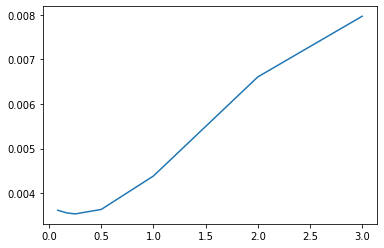

In [ ]:
data1=pd.read_csv('/content/DataMar.csv')

data1[['Date','Expiry Date']] = data1[['Date','Expiry Date']].apply(pd.to_datetime) 
data1['TimeUntilExpiration'] = ((data1['Expiry Date'] - data1['Date']).dt.days)/365
data1=data1[data1['Call/Put']==0]
data1 = data1.loc[(data1['Date'] == '2020-03-17')]
data1 = data1.loc[(data1['TimeUntilExpiration'] <= 0.95)&(data1['TimeUntilExpiration']!=0)]
data1=data1[data1['Bid Price']!=0]

from scipy.optimize.minpack import curve_fit
#interest rate calibration
data11=pd.read_csv('/content/int rates.csv')

arr1=np.array(data11[1:])
arr2=np.array(arr1[1:,1:])
print(arr1[51])
yield_maturities=np.array([1/12,2/12,3/12,6/12,1,2,3])
curve_fit, status = calibrate_nss_ols(yield_maturities,arr2[51].astype(float)/100) 
NSS_Fwd = NelsonSiegelSvenssonCurve.zero(curve_fit,yield_maturities)
plt.plot(yield_maturities,NSS_Fwd)

data1['rate']=data1['TimeUntilExpiration'].apply(curve_fit)

In [ ]:
from numpy import ma

tau=data1['TimeUntilExpiration'].to_numpy('float')

data1['Mid']=(data1['Bid Price']+data1['Ask Price'])/2
# print(data1['Mid'])

strikes=data1['Strike']
strikes=strikes.to_numpy('float')
rates=data1['rate']

sigmaSurface=data1[data1['Call/Put']==0][['TimeUntilExpiration','Strike','Mid']]


a=np.array(sigmaSurface['Mid'])
r = data1['rate'].to_numpy('float')


b=sigmaSurface.pivot_table('Mid', 'TimeUntilExpiration', 'Strike',dropna=False)
print(b.to_string())




tau2 = data1.loc[(data1['TimeUntilExpiration'] < 0.019179)&(data1['TimeUntilExpiration'] > 0.019177)]
# plt.plot(25.56/tau2['Strike'],tau2['Mid'],'+') #t
# plt.plot(25.56/tau2['Strike'],a,'x') 
# print(len(tau2))
# 23


Strike               15.50  16.00  16.25  16.50  16.75  17.00  17.25  17.50  17.75  18.00  18.25  18.50  18.75  19.00  19.25  19.50  19.75  20.00  20.25  20.50  20.75  21.00  21.25  21.50  21.75  22.00  22.25  22.50  22.75  23.00  23.25  23.50  23.75  24.00  24.25  24.50  24.75  25.00  25.25  25.50  25.75  26.00  26.25  26.50  26.75  27.00  27.50  28.00  28.50  29.00  29.50  30.00  30.50
TimeUntilExpiration                                                                                                                                                                                                                                                                                                                                                                                   
0.008219               NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  0.905    NaN  0.525    NaN  0.500    NaN  0.190    NaN  0.130    NaN  0.110  0.125    NaN    NaN    NaN   

In [ ]:
def cfBatesGeneric(phi,S0,kappa,theta,rho,v0,sigma,lambdJ,muJ,sigmaJ,q,T,r):
  
   d = np.sqrt((rho * sigma * 1j*phi - kappa)**2 + np.power(sigma,2) * (1j*phi + np.power(phi,2)))

   g = (kappa - rho*sigma*1j*phi - d) / (kappa - rho*sigma*1j*phi + d)

   cf1 = 1j*phi* np.log(S0) + 1j*phi*(r - q) * T

   cf2 = (theta*kappa / (np.power(sigma,2))) * (((kappa - rho*sigma*1j*phi - d) * T) - 2 * np.log((1 - g * np.exp(-d * T)) / (1 - g)))

   cf3 = ((v0/np.power(sigma,2))*(kappa-rho*sigma*1j*phi-d)*(1-np.exp(-d*T))) /  (1-g*np.exp(-d*T))

   cf4 = -(lambdJ*muJ*1j*T*phi) + lambdJ*T*(np.power((1+muJ),(1j*phi)) * np.exp(sigmaJ*(1j*phi/2) * (1j*phi-1))-1)

   cf = np.exp(cf1 + cf2 + cf3 + cf4)
   return cf 


def BatesModCfFFT(phi, S0,kappa,theta, rho,v0,sigma,lambdJ,muJ,sigmaJ,q,T,r, alpha):  

    NewPhi = phi - (alpha + 1)* 1j
    CF = cfBatesGeneric(NewPhi,S0,kappa,theta,rho,v0,sigma,lambdJ,muJ,sigmaJ,q,T,r)
    NumCF = np.exp(-r * T) * CF  
    DenCF = np.power(alpha, 2) + alpha - np.power(phi, 2) + 1j * phi * (2 * alpha + 1)
    
    return NumCF / DenCF
    
def CallBatesFFT(S0,v0, kappa,theta,sigma, rho,lambdJ,muJ,sigmaJ,q,T,r,K):
    
    alpha = 1.25
    NN = 4096 
    cc = 600
    eta = cc / NN
    Lambda = (2 * np.pi) / (NN * eta)
    bb = (NN * Lambda) / 2
    uu = np.array(range(1,NN + 1))
    ku = -bb + Lambda * (uu - 1)
    
    jj = np.array(range(1,NN + 1))
    
    NewPhi = eta * (jj - 1)
    ModCF = BatesModCfFFT(NewPhi, S0,kappa,theta, rho,v0,sigma,lambdJ,muJ,sigmaJ,q,T,r, alpha)
    
    delta = np.concatenate((1, np.zeros(NN-1)), axis = None)
    
    Simpson = (eta / 3) * (3 + np.power(-1j, jj) - delta)
    
    FuncFFT = np.exp(1j * bb * NewPhi) * ModCF * Simpson
    
    Payoff = np.real(np.fft.fft(FuncFFT))
    
    CallValues = (np.exp(-ku * alpha) / np.pi) * Payoff
    
    Positions = ((np.log(K) + bb) / Lambda) + 1
    
    return CallValues[Positions.astype(int)]


In [ ]:

# tau= np.array(tau).reshape([len(tau),1])
# r=np.array(rates).reshape([len(rates),1])
# strikes=np.array(strikes).reshape([len(strikes),1])
P1=(data1['Bid Price']+data1['Ask Price'])/2
P1 =P1.to_numpy('float')
# P1=np.array(P1).reshape([len(P1),1])


r = data1['rate'].to_numpy('float')
K = data1['Strike'].to_numpy('float')
tau = data1['TimeUntilExpiration'].to_numpy('float')
lenT = len(tau)
lenK = len(data1['Strike'])

params = {"kappa": {"x0":0.001000000000000001, "lbub": [.001,.3]}, #mean reversion speed 
          "theta": {"x0":0.6291157028699953, "lbub": [.01,.9]}, # long term  variance
          "sigma": {"x0":  0.9594935094448436, "lbub": [.001,4]}, #vol of vol
          "rho": {"x0": -1, "lbub": [-1,-.3]},
          "v0": {"x0":0.02894273551673686, "lbub": [0.001,.8]},
          "lambdJ": {"x0":-0.08656033652358813, "lbub": [-1,6]}, #jump frequency
          "muJ":{"x0":-.12,'lbub':[-5,5]}, 
          'sigmaJ':{"x0":0.014691143902636839,'lbub':[0,1]}
          }
x0 = [param["x0"] for key, param in params.items()]
bnds = [param["lbub"] for key, param in params.items()]

   
def SqErr(x):

    q=.03
    v0, kappa, theta, sigma, rho, lambdJ,muJ,sigmaJ = [param for param in x]    
    P2=[]
    bates_prices=[]  
    ModelRes = np.zeros(lenT)
    weights=np.power(np.absolute(data1['Bid Price']-data1['Ask Price']),2)
    weights=np.array(weights).reshape([len(weights),1])



    for i in range(lenK):
      ModelRes = CallBatesFFT(19.36,kappa,theta,sigma, rho,v0,lambdJ,muJ,sigmaJ,q,tau[i], r[i], strikes[i])
      bates_prices.append(ModelRes)
      P2.append(P1[i])
    P2=np.array(P2).reshape([len(P2),1])
    bates_prices=np.array(bates_prices).reshape([len(bates_prices),1])
    err=np.sum(np.power((bates_prices - P2),2))/len(P2)
    return err

result = minimize(SqErr, x0, tol = 1e-3, method='Nelder-Mead', bounds=bnds,options={ 
                                 "disp": True, 
                                 "adaptive": True,'fatol':.001,'xatol':.001,'maxiter':3200
                                 })
kappa, theta, sigma, rho,v0, lambdJ,muJ,sigmaJ= [param for param in result.x]
kappa, theta, sigma, rho,v0, lambdJ,muJ,sigmaJ


NameError: ignored